# AeroAcoustics.jl
This notebook demonstrates the basic functionality of the AeroAcoustics.jl package.

First obtain a version of julia from https://julialang.org, start the application and run:
```
] add https://gitlab.windenergy.dtu.dk/ollyl/AeroAcoustics.jl.git
```

Now run the tests to see if everything runs smoothly  
```
using AeroAcoustics
] test AeroAcoustics
```

In [12]:
using AeroAcoustics
using Pkg
pkg"test AeroAcoustics"

   Testing AeroAcoustics
 Resolving package versions...
 ──────────────────────────────────────────────────────────────────────────────
                                       Time                   Allocations      
                               ──────────────────────   ───────────────────────
       Tot / % measured:            24.2s / 63.4%           2.97GiB / 67.5%    

 Section               ncalls     time   %tot     avg     alloc   %tot      avg
 ──────────────────────────────────────────────────────────────────────────────
 compute csm                1    8.93s  58.3%   8.93s   0.94GiB  46.9%  0.94GiB
 compute steeringvec        1    2.61s  17.0%   2.61s    459MiB  22.4%   459MiB
 compute env                1    1.49s  9.70%   1.49s    195MiB  9.50%   195MiB
 compute beamforming        1    930ms  6.07%   930ms    195MiB  9.50%   195MiB
 compute psf                1    669ms  4.36%   669ms   98.3MiB  4.79%  98.3MiB
 DAMAS single freq          1    482ms  3.14%   482ms    121MiB

The testset downloads to example files, that are stored in the .julia directory. Something similar to
```
~/.julia/packages/AeroAcoustics/Dlv4w/test/data
```
Find the files and copy their path.

Now, start by importing the datasets. If it has not previously been added, run
```
]add HDF5
```

In [2]:
using HDF5

In [3]:
srcdir = "/Users/oliver/.julia/packages/AeroAcoustics/Dlv4w/test/data/test1_timeseries.h5"
t = h5read(srcdir, "MicrophoneData/microphoneDataPa")
fs = h5read(srcdir, "MicrophoneData/fs")

65536

Now compute the cross spectral matrix, optionally also add DSP
```
]add DSP
```

In [4]:
using DSP

In [5]:
CSM = csm(t;n=1024,noverlap=div(1024,2),fs=fs,win=DSP.hanning(1024));

The output of `csm` is a `FreqArray` that holds both the CSM data and the corresponding frequency bins

Now read the microphone geometry and start setting up beamforming

In [6]:
micgeom = h5read(srcdir, "MicrophoneData/arrayGeom")

3×84 Array{Float64,2}:
 -0.16772   -0.36164   -0.37212  -0.57652   …  -0.82407  -0.61627  -0.63689
  0.095093   0.041345   0.20259   0.057883     -0.52936  -0.52079  -0.73896
  0.0        0.0        0.0       0.0           0.0       0.0       0.0    

Setup the computational environment with `Environment` struct

In [7]:
?Environment

search: Environment



```
Environment
```

The Environment struct is required for most methods and defines the geometrical setup, constants, and stores the relevant data together. The fields are

# Arguments

*Required:*

  * `micgeom::Array{T,2}`: (x,y,z) coordinates for microhone array.
  * `z0::Real`: distance to source plane from microphone array.
  * `CSM::FreqArray`: Cross-spectral matrix, size `M x M x Nf`, where `M` is the number of microphones and `Nf` is the number of frequency bins.

*Optional:*

  * `flim::Tuple=extrema(CSM.fc)`: Frequency limits (fmin,fmax).
  * `Nx::Integer=21`: Number of computational gridpoint in x direction.
  * `Ny::Integer=21`: Number of computational gridpoint in y direction.
  * `xlim::Tuple=(-1.,1.)`: Cartesian x-coordinate limits.
  * `ylim::Tuple=(-1.,1.)`: Cartesian y-coordinate limits.
  * `c::Real=343.`: Speed of sound [m/s].
  * `Ma::Real=0.0`: Mach number.
  * `h::Real=0.0`: Distance to shear layer (Amiet correction) should be supplied when `Ma != 0`.


In [8]:
env = Environment(z0=1.6,
                  micgeom=micgeom,
                  Nx = 21,
                  Ny = 21,
                  flim=(100,10000),
                  xlim=(-0.5,0.5),
                  ylim=(-0.5,0.5),
                  CSM=CSM);

Compute steering vectors (is stored in env when using mutating method `!`) and beamforming

In [9]:
steeringvectors!(env)
b = beamforming(env);

Plot results

In [10]:
using Plots

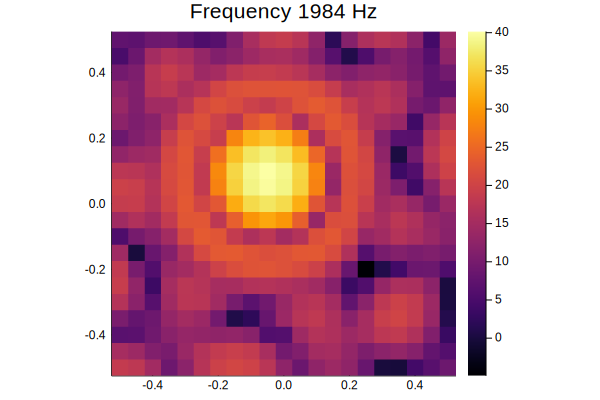

In [11]:
heatmap(env.rx,env.ry,reshape(SPL.(b[:,30]),env.Nx,env.Ny)',aspect_ratio=1,title="Frequency $(env.fn[30]) Hz")